## K-Means Clustering

The common practice to group/cluster customers in a marketing environment is through RFM Analysis
- Recency : how recently did the customer purchase
- Frequency : how often do they purchase
- Monetary value : how much do they spend

**Overview**<br>
<a href="https://archive.ics.uci.edu/ml/datasets/online+retail">Online retail is a transnational data set</a> which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

The steps are broadly:
1. Read and understand the data
2. Clean the data
3. Prepare the data for modelling
4. Modelling
5. Final analysis and reco

# 1. Read and visualise the data

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [8]:
# read the dataset
retail_df = pd.read_csv(r"D:\Upgrad - PG diploma - datascience\Course 2_ML-I\Unsupervised Learning Clustering\Online+Retail.csv", sep=",", encoding="ISO-8859-1", header=0)
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [9]:
# basics of the df
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# 2. Clean the data

In [10]:
# missing values
round(100*(retail_df.isnull().sum())/len(retail_df), 2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [11]:
# we cannot drop customer id as it is really important column...
# drop all rows having missing values
retail_df = retail_df.dropna()
retail_df.shape

(406829, 8)

In [12]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


For finding monetory related stuff we need to find the amount i.e total money 

In [13]:
# new column: amount 
retail_df['amount'] = retail_df['Quantity']*retail_df['UnitPrice']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


# 3. Prepare the data for modelling

- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [14]:
# monetary
grouped_df = retail_df.groupby('CustomerID')['amount'].sum()
grouped_df = grouped_df.reset_index()
grouped_df.head()

,CustomerID,amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [15]:
# frequency
frequency = retail_df.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index()
frequency.columns = ['CustomerID', 'frequency']
frequency.head()

,CustomerID,frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [16]:
# merge the two dfs
grouped_df = pd.merge(grouped_df, frequency, on='CustomerID', how='inner')
grouped_df.head()

,CustomerID,amount,frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [17]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [18]:
# recency
# convert to datetime
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'], 
                                          format='%d-%m-%Y %H:%M')

In [19]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [20]:
# compute the max date
# this is the referrence date i.e of all the transactions in the data the most recent transaction is taken as referenne date. and for every customer among his transactions we check which is the latest transaction and we check how far this latest transaction is from the reference dte
max_date = max(retail_df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [21]:
# compute the diff
retail_df['diff'] = max_date - retail_df['InvoiceDate']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [22]:
# recency
last_purchase = retail_df.groupby('CustomerID')['diff'].min()
last_purchase = last_purchase.reset_index()
last_purchase.head()

,CustomerID,diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [23]:
# merge
grouped_df = pd.merge(grouped_df, last_purchase, on='CustomerID', how='inner')
grouped_df.columns = ['CustomerID', 'amount', 'frequency', 'recency']
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [24]:
# number of days only
grouped_df['recency'] = grouped_df['recency'].dt.days
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


{'whiskers': [<matplotlib.lines.Line2D at 0x137f36b3a88>,
 'caps': [<matplotlib.lines.Line2D at 0x137f36d2fc8>,
 'boxes': [<matplotlib.lines.Line2D at 0x137f36bae48>],
 'medians': [<matplotlib.lines.Line2D at 0x137f36dde88>],
 'fliers': [<matplotlib.lines.Line2D at 0x137f36ddf88>],
 'means': []}

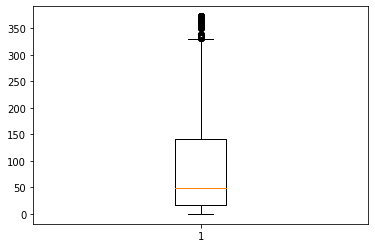

In [25]:
# 1. outlier treatment
plt.boxplot(grouped_df['recency'])

In [26]:
# two types of outliers:
# - statistical : these are points outside whiskers i.e from the above boxplot finding outliers and removing them
# - domain specific : related to business problem domain....i.e sometimes you look at data and some look very much outlied .

It is better to do cluster analysis both with outliers and without outliers and check both to understand whether outliers have drastic affecet on cluster anlayss 

In other words first do cluster analysis with outliers now after doing this , we plot how clusters are distributed with box plot if the box plots we got are very unlikely like if we look at the one year data and in frequency box plot of a cluster we found that there are pooints which have frequency of 10000 which is very highly unlikely.....and will affect our anlaysis therefore better to remove them and do cluster analyssi without outliers

In [27]:
# removing (statistical) outliers
Q1 = grouped_df.amount.quantile(0.05)
Q3 = grouped_df.amount.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.amount >= Q1 - 1.5*IQR) & (grouped_df.amount <= Q3 + 1.5*IQR)]

# outlier treatment for recency
Q1 = grouped_df.recency.quantile(0.05)
Q3 = grouped_df.recency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.recency >= Q1 - 1.5*IQR) & (grouped_df.recency <= Q3 + 1.5*IQR)]

# outlier treatment for frequency
Q1 = grouped_df.frequency.quantile(0.05)
Q3 = grouped_df.frequency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.frequency >= Q1 - 1.5*IQR) & (grouped_df.frequency <= Q3 + 1.5*IQR)]



In [28]:
# 2. rescaling
rfm_df = grouped_df[['amount', 'frequency', 'recency']]

# instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4293, 3)

In [29]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['amount', 'frequency', 'recency']
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


One more important data preparation technique that we also need to do but have skipped in the demonstration is the calculation of the Hopkins Statistic. In python, you can use the following code snippet to pass a dataframe to the Hopkins statistic function to find if the dataset is suitable for clustering or not. You can simply copy-paste the code present in the code given below to the main dataset and analyse the Hopkins statistic value.

code snipet is downloadedm

Notes regarding Hopkins Statistic

You don't need to know how the algorithm of  Hopkins Statistic works. The algorithm is pretty advanced and hence you don't need to know its workings but rather only interpret the value that it assigns to the dataframe.
On multiple iterations of Hopkins Statistic, you would be getting multiple values since the algorithm uses some randomisation in the initialisation part of the code. Therefore it is advised to run it a couple of times before confirming whether the data is suitable for clustering or not.


this article has everything about hopkins stat : https://www.datanovia.com/en/lessons/assessing-clustering-tendency/

# 4. Modelling

In [30]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [31]:
kmeans.labels_

array([2, 3, 0, ..., 2, 0, 0])

In [32]:
help(KMeans)

Help on class KMeans in module sklearn.cluster._kmeans:

class KMeans(sklearn.base.TransformerMixin, sklearn.base.ClusterMixin, sklearn.base.BaseEstimator)
 |  KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=None, algorithm='auto')
 |  
 |  K-Means clustering.
 |  
 |  Read more in the :ref:`User Guide <k_means>`.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_clusters : int, default=8
 |      The number of clusters to form as well as the number of
 |      centroids to generate.
 |  
 |  init : {'k-means++', 'random'} or ndarray of shape             (n_clusters, n_features), default='k-means++'
 |      Method for initialization, defaults to 'k-means++':
 |  
 |      'k-means++' : selects initial cluster centers for k-mean
 |      clustering in a smart way to speed up convergence. See section
 |      Notes in k_init for more details.
 |  
 |      'random': choose k observations (row

## Finding the Optimal Number of Clusters

Now you might be thinking why the number of clusters is taken as 4 and not any other number. To find the optimum number of clusters, we use two techniques - the elbow curve method and the silhouette score method. Let's learn about both of them in detail in the following lecture



### SSD



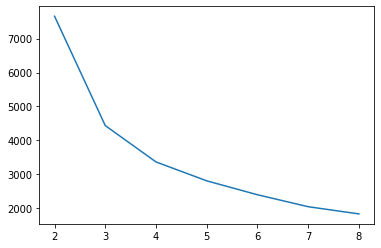

In [33]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    #inertia : Sum of squared distances of samples to their closest cluster center.
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(range_n_clusters,ssd)

the thing is ofcourse as no of cluster centers increases the inertia will obviously decrease ,optimal number of cluster centers is obtained from where adding more cluster centers we donot notice that big of a drop of ineetia for example if you see above graph there is a big drop of inertia from 2 centers to 3 centers therefore 3 adding one more to 2 centers actually contriubtes a lot but from 3 we see there is not a significant drop therfore adding more doesnot contribute 

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

Silhouette anlaysis works on the principle that inter cluster distance should be more and intra cluster distance should be less

see downloaded video in the laptop for more understanding of silhouette analysis

In [34]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
plt.plot(range_n_clusters,)

For n_clusters=2, the silhouette score is 0.5415858652525395
For n_clusters=3, the silhouette score is 0.5084896296141937
For n_clusters=4, the silhouette score is 0.4781841150952288
For n_clusters=5, the silhouette score is 0.4662700564189704
For n_clusters=6, the silhouette score is 0.41745936086609203
For n_clusters=7, the silhouette score is 0.41768907282021733
For n_clusters=8, the silhouette score is 0.4118170576341453


So from elbow method we think 3 is the best choice but from the above silhouette analysis we understood that 2 has bigger score than 3 so what to take basically we can take any of 2 or 3 based on business context just because 2 has higher silhouette score doesnot mean we have to take 2 as optimal cluster centers we can take 2 or 3 based on business context

In [35]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [36]:
kmeans.labels_

array([1, 2, 0, ..., 1, 0, 0])

In [37]:
# assign the label
grouped_df['cluster_id'] = kmeans.labels_
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,1
1,12347.0,4310.00,182,1,2
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,1


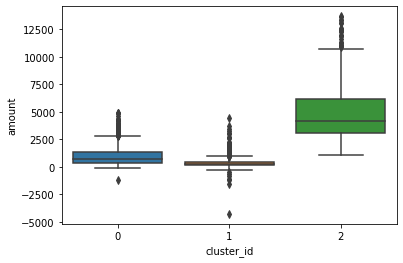

In [38]:
# plot
sns.boxplot(x='cluster_id', y='amount', data=grouped_df)

We see customers of cluster 1 paid a lottt....therefore those ar evaluable 

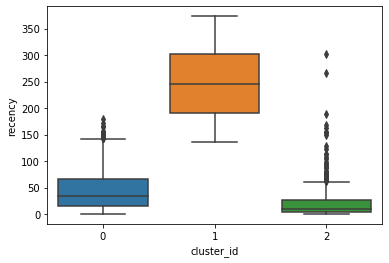

In [39]:
# plot
sns.boxplot(x='cluster_id', y='recency', data=grouped_df)

Also we see cluster 0 are very recent customers therefore concnetrating on them will be beneficial

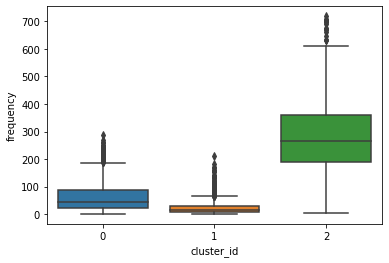

In [40]:
# plot
sns.boxplot(x='cluster_id', y='frequency', data=grouped_df)

Also customers of cluster 1 has more frequency therefore concentrating on them is useful

# Other Behavioural Segmentation Types

You have seen what RFM segmentation is. Now, you will look at other segmentation types commonly used in the industry.

See video downloaded in laptop



You looked at RPI segmentation, which looks at what kind of relationship you have had with the person before, what type of person he/she is, and the intent of the person at the time of buying.

 

You also looked at the CDJ segmentation, which looks at the path that customers take while experiencing your product.

# Summary

So what did you learn in this session?

 

You learnt how to create clusters using the K-means algorithm in Python with the analysis of the Online Store data set. We wanted to group the customers of the store into different clusters based on their purchasing habits. The different steps involved were:

- Missing values treatment

- Data transformation

- Outlier treatment

- Data standardisation

- Finding the optimal value of K

- Implementing K Means algorithm

- Analysing the clusters of customers to obtain business insights

 

Once we are through with the data preparation, the K-means algorithm is quite easy to implement. All it takes is running the KMeans() function. The only ambiguous point you may notice here is that you need to decide the number of required clusters beforehand and in fact run the algorithm multiple times with a different number K before you can figure out the most optimal number of clusters.

 

This is also what happens in the industry practices that we run the algorithm multiple times with different values of K and then pick the clusters which make the most business sense. In fact, the k-means algorithm finds a large application in the industry. For example, it can be used to find out the most optimal centre to install mobile towers by clustering the customers geographically. Similarly, it has wide application in medical science, where say the patients can be clustered together on the basis of their symptoms, and then analysed to figure out the cause of their illness.

 

However, K means was just one of the clustering algorithm. In the next session, we will learn about another clustering algorithm called hierarchical clustering, which does not require you to decide the number of clusters beforehand.

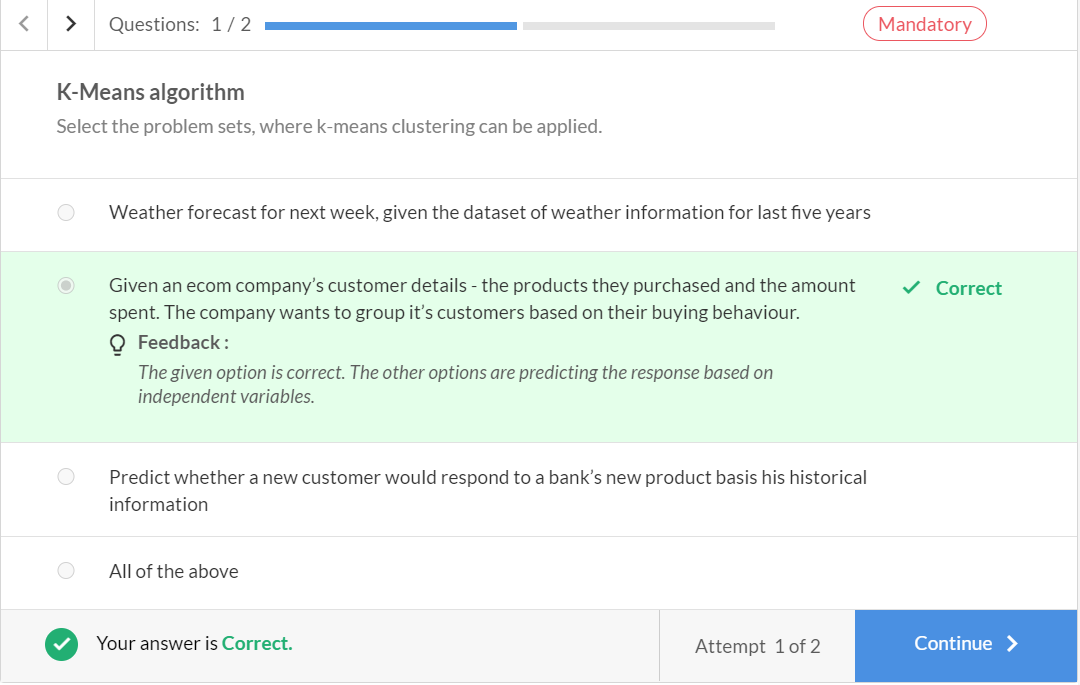

In [42]:
from IPython.display import Image
Image("D:/Capture.png")

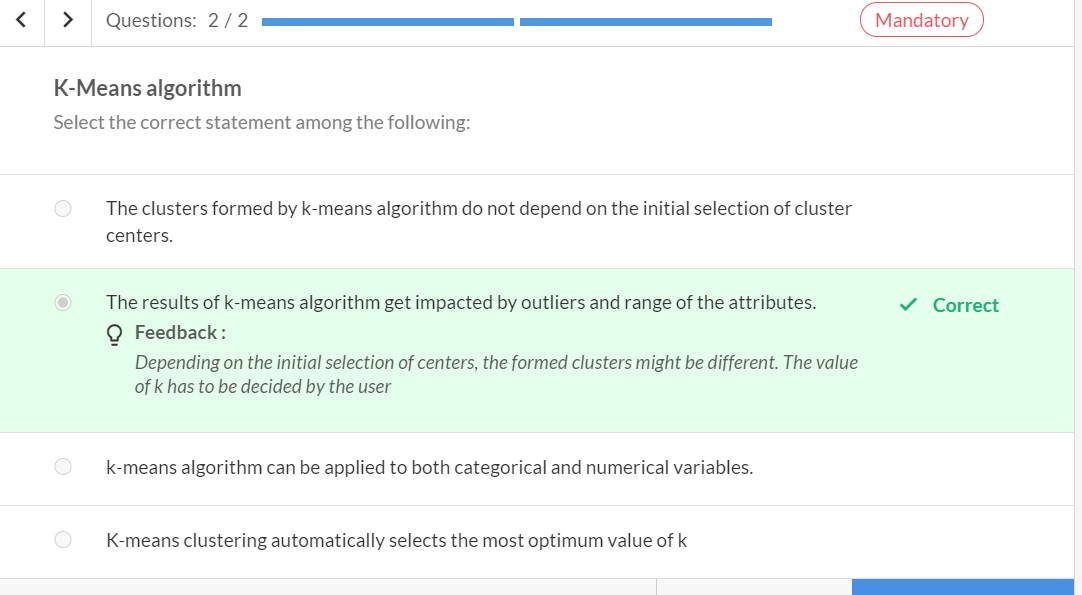

In [43]:
from IPython.display import Image
Image("D:/Capture.png")

# Concepts of Hierarchical Clustering

Welcome to the session on 'Hierarchical Clustering'. In the previous sessions, you got a basic understanding of what clustering is and how you can use the K-Means algorithm to create clusters in your data set. You also saw the execution of the K-Means algorithm in Python.

 

In this session
You will learn about another algorithm to achieve unsupervised clustering. This is called Hierarchical Clustering. Here, instead of pre-defining the number of clusters, you first have to visually describe the similarity or dissimilarity between the different data points and then decide the appropriate number of clusters on the basis of these similarities or dissimilarities.

 

You will learn about:

- Hierarchical clustering algorithm
- Interpreting the dendrogram
- Cutting the dendrogram
- Types of linkages

### Hierarchical Clustering Algorithm

One of the major considerations in using the K-means algorithm is deciding the value of K beforehand. The hierarchical clustering algorithm does not have this restriction.

 

The output of the hierarchical clustering algorithm is quite different from the K-mean algorithm as well. It results in an inverted tree-shaped structure, called the dendrogram. An example of a dendrogram is shown below.

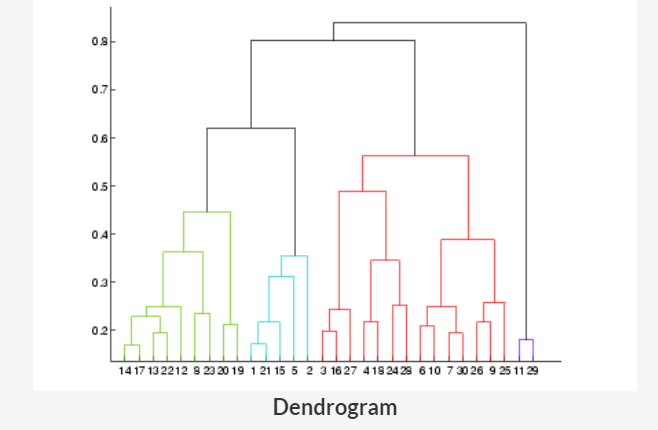

In [5]:
from IPython.display import Image
Image("D:/Capture.png")

SEE hierarchical clustering video downloaded in laptopm

In the K-Means algorithm, you divided the data in the first step itself. In the subsequent steps, you refined our clusters to get the most optimal grouping. In hierarchical clustering, the data is not partitioned into a particular cluster in a single step. Instead, a series of partitions/merges take place, which may run from a single cluster containing all objects to n clusters that each contain a single object or vice-versa.

 

This is very helpful since you don’t have to specify the number of clusters beforehand.

 

Given a set of N items to be clustered, the steps in hierarchical clustering are:

- Calculate the NxN distance (similarity) matrix, which calculates the distance of each data point from the other
- Each item is first assigned to its own cluster, i.e. N clusters are formed
- The clusters which are closest to each other are merged to form a single cluster
- The same step of computing the distance and merging the closest clusters is repeated till all the points become part of a single cluster

 

Thus, what you have at the end is the dendrogram, which shows you which data points group together in which cluster at what distance

### Interpreting the Dendrogram

The result of the cluster analysis is shown by a dendrogram, which starts with all the data points as a separate cluster and indicates at what level of dissimilarity any two clusters were joined.

https://towardsdatascience.com/agglomerative-clustering-and-dendrograms-explained-29fc12b85f23

You also saw that hierarchical clustering can proceed in 2 ways — agglomerative and divisive. If you start with n distinct clusters and iteratively reach to a point where you have only 1 cluster in the end, it is called agglomerative clustering. On the other hand, if you start with 1 big cluster and subsequently keep on partitioning this cluster to reach n clusters, each containing 1 element, it is called divisive clustering.

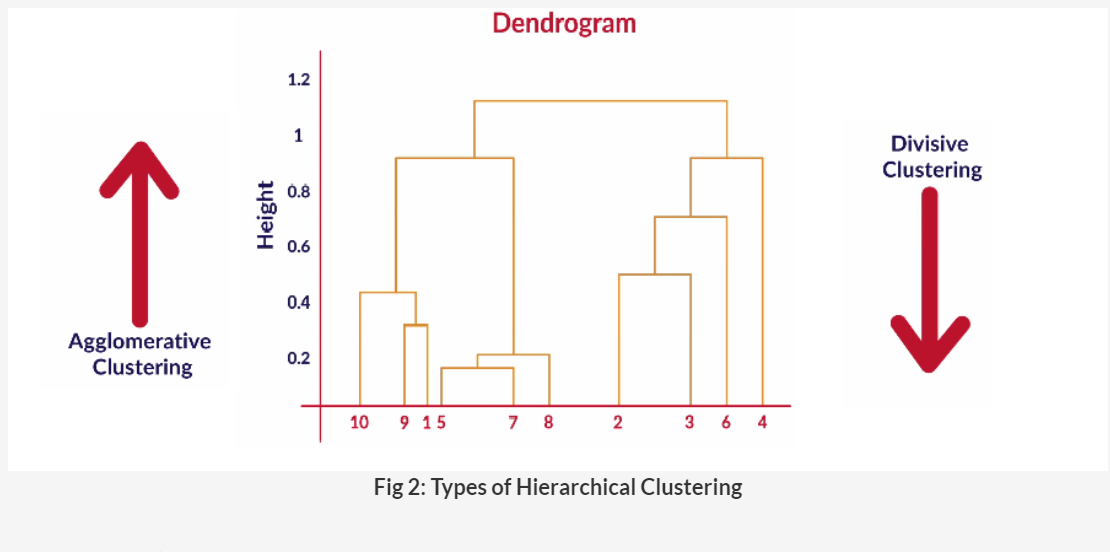

In [2]:
from IPython.display import Image
Image("D:/Capture.png")

height column represents the distance 

https://nlp.stanford.edu/IR-book/html/htmledition/divisive-clustering-1.html

http://luthuli.cs.uiuc.edu/~daf/courses/probcourse/notesclustering.pdf

Hierarchical clustering is used for outlier detectionm

### Types of Linkages

In our example, we took the minimum of all the pairwise distances between the data points as the representative of the distance between 2 clusters. This measure of the distance is called a single linkage. Apart from using the minimum, you can use other methods to compute the distance between the clusters.

http://www.saedsayad.com/clustering_hierarchical.htm
    
https://stats.stackexchange.com/questions/195446/choosing-the-right-linkage-method-for-hierarchical-clustering
    
http://www.stat.cmu.edu/~ryantibs/datamining/lectures/05-clus2.pdf

Let’s see once again the different types of linkages.

- Single Linkage: Here, the distance between 2 clusters is defined as the shortest distance between points in the two clusters
- Complete Linkage: Here, the distance between 2 clusters is defined as the maximum distance between any 2 points in the clusters
- Average Linkage: Here, the distance between 2 clusters is defined as the average distance between every point of one cluster to every other point of the other cluster.
 

You have to decide what type of linkage should be used by looking at the data. One convenient way to decide is to look at how the dendrogram looks. Usually, a single linkage-type will produce dendrograms which are not structured properly , whereas complete or average linkage will produce clusters which have a proper tree-like structure

Let's recall what you have learnt in this session so far. You learnt about another clustering technique called Hierarchical clustering. You saw how it is different from K-Means clustering. One major advantage is that you do not have to pre-define the number of clusters. However, since you compute the distance of each point from every other point, it is time-consuming and needs a lot of processing power.

The hierarchical clustering involves 2 basic steps:

- Creating the dendrogram
- Cutting the dendrogram at an appropriate level

Now let's go ahead and utilise the single linkage method for clustering this dataset.

## Hierarchical Clustering

In [41]:
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


In [42]:
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,1
1,12347.0,4310.00,182,1,2
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,1


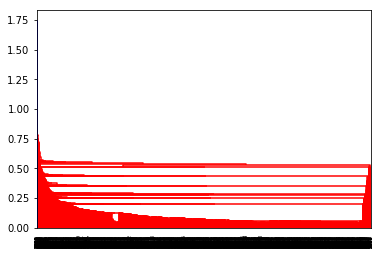

In [408]:
# single linkage
mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

As you can clearly see, single linkage doesn't produce a good enough result for us to analyse the clusters. Hence, we need to go ahead and utilise the complete linkage method and then analyse the clusters once again.

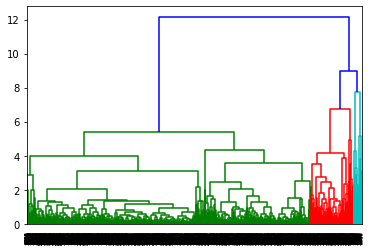

In [44]:
# complete linkage
mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [45]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 0, ..., 0, 0, 0])

In [46]:
# assign cluster labels
grouped_df['cluster_labels'] = cluster_labels
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id,cluster_labels
0,12346.0,0.00,2,325,1,0
1,12347.0,4310.00,182,1,2,1
2,12348.0,1797.24,31,74,0,0
3,12349.0,1757.55,73,18,0,0
4,12350.0,334.40,17,309,1,0


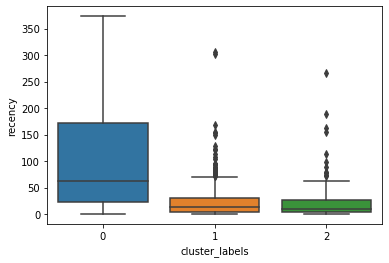

In [47]:
# plots
sns.boxplot(x='cluster_labels', y='recency', data=grouped_df)

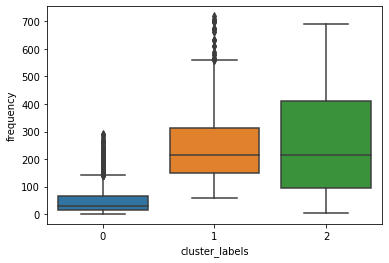

In [48]:
# plots
sns.boxplot(x='cluster_labels', y='frequency', data=grouped_df)

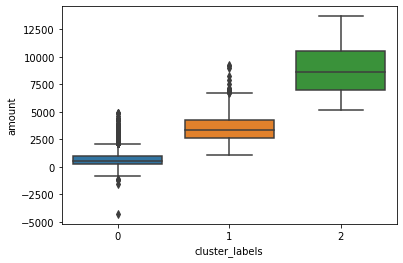

In [49]:
# plots
sns.boxplot(x='cluster_labels', y='amount', data=grouped_df)

our main goal is cluster must be differnet from other

Here from the above box plots we can understand 3 number of clusters is the best choice....becuase even though medians of cluster 1 and 2 looks same in frequency plot and recency plot (same medians means clusters are kind of similar ),difference between medians of clusters (difference betweeen clusters) is more evident in amount plot.

Therefire 3 is a good choice coz in the end difference is evident in atleast one of the plots. which gave us info

After we got the clusterIDs for each customer, we then appended the obtained ClusterIDs to the RFM data set, and analysed the characteristics of each cluster to derive the business insights from the different customer segments or clusters, in the same way as you did for the K-Means algorithm.

### Industry Insights

Now let's hear from our industry experts regarding the comparison between the K-Means algorithm and the Hierarchical clustering algorithm, before learning how to choose between the two based on your business problem.

K means takes less time than hierarchical clustering because time complexity of k means is O(iterations*k*n) which is O(n) but time complexity of hierarchical clustering is O(n^2)

In K Means clustering, since we start with random choice of clusters, the results produced by running the algorithm multiple times might differ. While results are reproducible in Hierarchical clustering.

No of clusters should be in between [2,15] coz beyond 15 means it is difficult to interpret

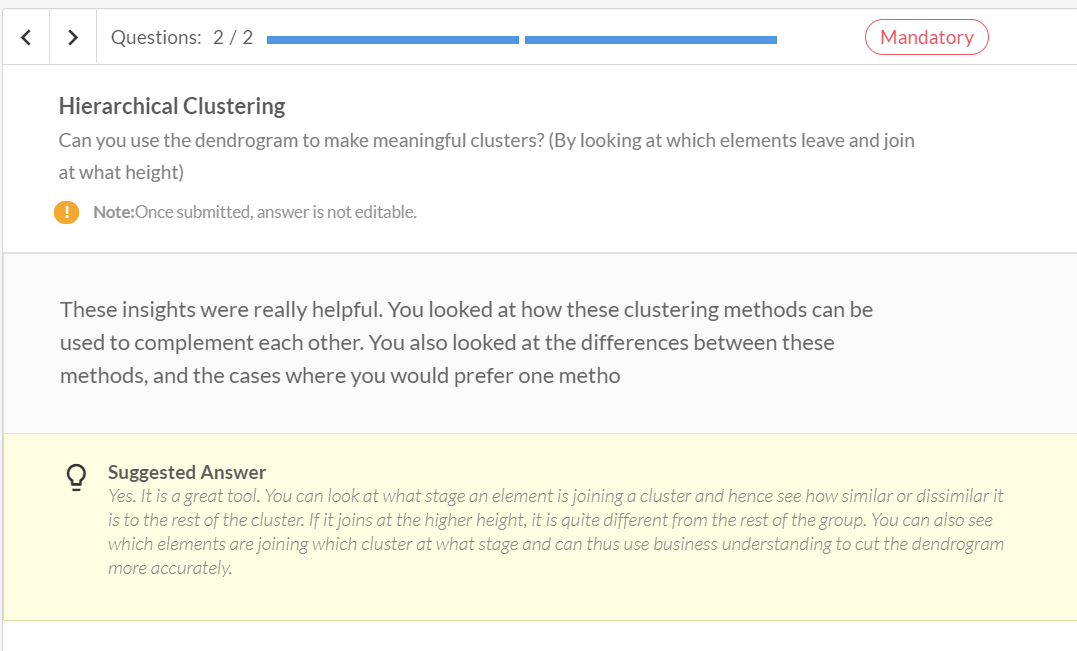

In [50]:
from IPython.display import Image
Image("D:/Capture.png")

# K mode clustering

In the previous session we learned in detail about the K-Means algorithm, we looked at the two steps, i.e. assignment step and the optimisation step in which the K-Means algorithm works iteratively. 

 

The K-Means clustering algorithm is undoubtedly one of the most widely used partitional algorithms for numerical data or continuous data, but K-Means can't handle categorical data, and the reason is that of the difference in the dissimilarity measure the K-Means uses.

 

The K-modes clustering algorithm is based on K-means paradigm but removes the numeric data limitation while preserving its efficiency.

K mode is useful for clustering categorical variables . Like here it is same as k measn that we start with k centers now the dissimilarity/distance between two clusters is defined as ....no of attributes/columns between X and Y which are different .

K-modes Algorithm uses modes instead of means to form clusters of categorical data.

 

Steps of the algorithm.

- Randomly assign “K” number of modes.
- Calculate the dissimilarity score between each of the remaining data points from the “K” number of chosen modes.
- Associate the data points to the mode whose score is minimum.
- Repeat from step 2 until there is no reassignment of clusters or when cost function is minimized.

Here inititalsing cluster centers can be done in 2 ways.
- Huang method
- Cao method

What do you think about a data set having both numerical and categorical values? Will the above methods do the job? Here comes the K-Prototype. That’s the simple combination of K-Means and K-Modes in clustering mixed attributes.

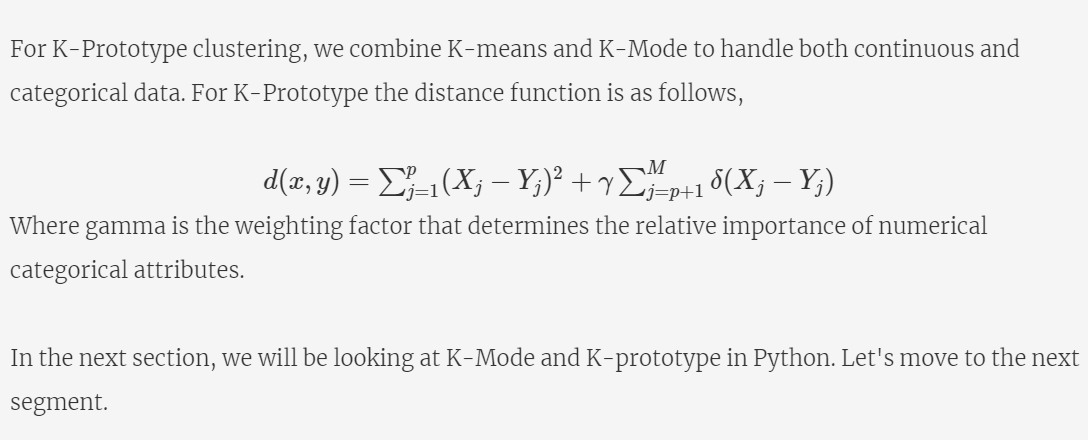

In [1]:
from IPython.display import Image
Image("D:/Capture.png")

For K-Mode in python, we will be required to install an additional library. You may download the Kmode library using the steps mentioned in this document. : https://pypi.org/project/kmodes/

Remember that to use KModes in Anaconda, you need to install KModes using the conda installer in Anaconda Prompt.

 

Kmodes can be initialised using two main methods namely "Hunag" and "Cao". 

 

To read in detail about the "Huang" initialisation technique you may read this document. You may also read about "Cao" initialisation technique here.

https://www.semanticscholar.org/paper/CLUSTERING-LARGE-DATA-SETS-WITH-MIXED-NUMERIC-AND-Huang/d42bb5ad2d03be6d8fefa63d25d02c0711d19728?p2df

http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.474.8181&rep=rep1&type=pdf

https://grid.cs.gsu.edu/~wkim/index_files/papers/kprototype.pdf

# DB Scan Clustering

This is reading session, you are required to go through the text and understand the basic idea behind DBScan. You may also go through the link provided at the end, to better understand the topic.

 

DBSCAN is a density-based clustering algorithm that divides a data set into subgroups of high-density regions. DBSCAN groups together point that are close to each other based on a distance measurement (usually Euclidean distance) and a minimum number of points. It also marks as outliers the points that are in low-density regions.

DBScan Parameters
DBSCAN algorithm requires 2 parameters:

- Epsom or EPS
- MinPoints or MinSamples.



EPS is a distance parameter that defines the radius to search for nearby neighbours. We can imagine each data point having a circle with radius EPS drawn around it. 

 

The value of EPS taken to cluster the data has a significant impact on the results. If the value of EPS is considered too small, decidedly fewer data points will be considered in one cluster, and a large part of the data will not be clustered. The un-clustered data points will be considered as outliers because they don't satisfy the number of points to create a dense region. If the EPS value is chosen to be very high, no real clusters will be formed as all of them will merge in the same cluster. The eps should be chosen based on the distance of the dataset (we can use a k-distance graph to find it), but in general small eps values are preferable.

Min Samples
Min Samples or Min Points are the number of minimum points to form a dense region or cluster. For example, if we set the min_samples as 5, we need at least 5 points to form a dense cluster. 

 

Minimum points can be selected from some dimensions (D) in the data set, as a general rule min points >=D+1. 

 

The DBSCAN algorithm is used to find associations and structures in the data that are usually hard to find manually.

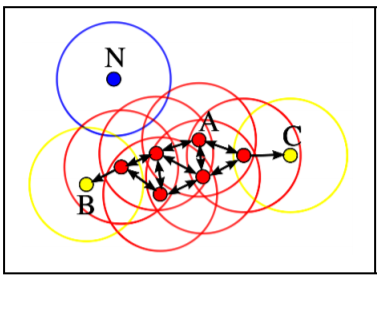

In [14]:
from IPython.display import Image
Image("D:/Capture.png")

Use this link to visualise the DBSCAN algorithm in action : https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/

Application of DBSCAN at Netflix: https://netflixtechblog.com/tracking-down-the-villains-outlier-detection-at-netflix-40360b31732

Application of DBSCAN in Geolocated data: https://www.oreilly.com/content/clustering-geolocated-data-using-spark-and-dbscan/

Original Paper on DBSCAN posted on KDD by Martin Ester: https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf

# Gaussian Mixture Model

K-Means algorithm’s inner-loop iterates over two steps:

- Assign each observation Xi to the closest cluster centroid μk
- Update each centroid to the mean of the points assigned to it.

So, for K-Means, every data point is assigned to any of the one clusters, this is known as Hard Clustering or Hard cluster assignment.

 

Hard Clustering: In hard clustering, the data points are assigned to any one cluster completely. That means for hard clustering there is no consideration of uncertainty in the assignment of a data points. 

 

The limitations with hard clustering are that we tend to clusters even those data points in one of the clusters, even if the data point doesn't follow the clustering trend completely. Forex, If we want to cluster the set of customers into two groups say "High-Value Customers" and "Low-Value Customers", we will end up clustering the average value customers to any one of the clusters.

 

So to overcome this issue, we have a concept of Soft Clustering.

 

Soft Clustering: In soft clustering, the assignment of the data point to a cluster is based on the probability or likelihood of that data point to existing in that cluster. If we take the above example of clustering the customers into two clusters, we will be able to identify those customers who didn't fall in any one.

 

For soft clustering, we have an algorithm called GMMs or Gaussian Mixture Models. GMM has two advantages over K-Means:
- GMM is a lot more flexible regarding cluster covariance.
- GMM model accommodates mixed membership.

You may go through this link to understand GMMs in more detail and how it works. GMMs is an optional session, which you may go through based on your time and convenience. We strongly suggest you go through the algorithm as GMMs can be applied to applications like "Speech Recognition", "Image Clustering", "Financial Applications". 

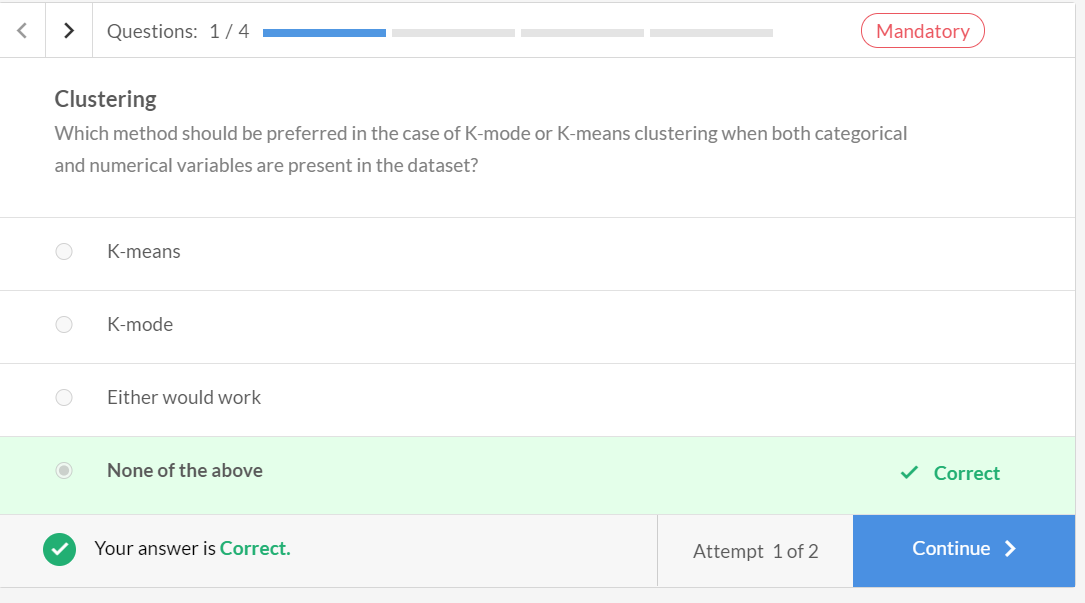

In [2]:
from IPython.display import Image
Image("D:/Capture.png")

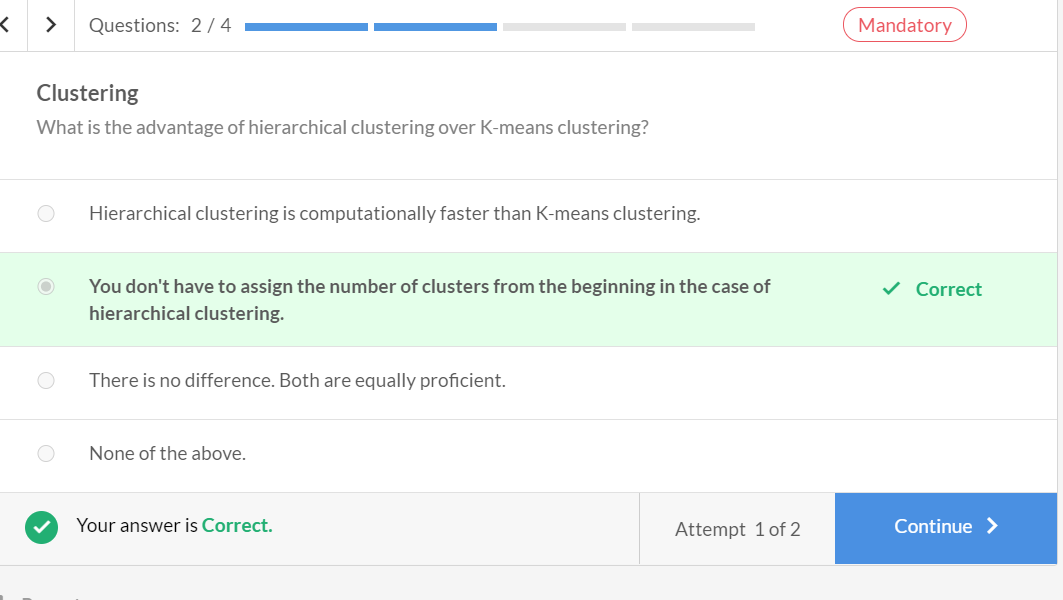

In [3]:
from IPython.display import Image
Image("D:/Capture.png")

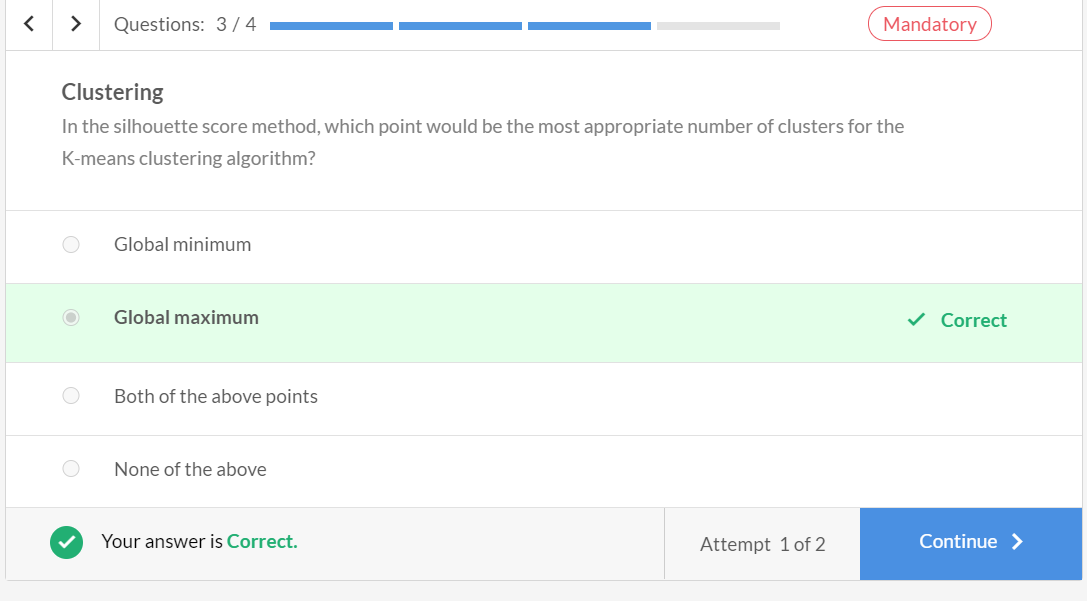

In [4]:
from IPython.display import Image
Image("D:/Capture.png")

Euclidean, Manhattan, Cosine, and Bregman divergence are some distance metrics used for the K-means algorithm. Euclidean is the squared distance from a data point to the centroid. Manhattan is the absolute distance from a data point to the centroid. Cosine is the cosine distance from a data point to the cluster centroid. Bregman divergence is a class of distance metrics that includes Euclidean, Mahalanobis, and Cosine. Basically, Bregman divergence includes all those distance metrics for which the mean is a centroid.



Initiation of the centroids in a cluster is one of the most important steps of the K-means algorithm. Many times, random selection of initial centroid does not lead to an optimal solution. In order to overcome this problem, the algorithm is run multiple times with different random initialisations. The sum of squared errors (SSE) are calculated for different initial centroids. The set of centroids with the minimum SSE is selected. Even though this is a very simple method, it is not foolproof. The results of multiple random cluster initialisations will depend on the dataset and the number of clusters selected, however, that still will not give an optimum output every time.  

The other method involves first selecting the centroid of all the data points. Then, for each successive initial centroid, select the point which is the farthest from the already selected centroid. This procedure will ensure that the selection is random, and the centroids are far apart. The disadvantage of this method is that calculating the farthest point will be expensive. In order to avoid this problem, initialisation is carried out on a subset of the dataset.

How are outliers handled by the K-means algorithm?

Handling of outliers differs from case to case. In some cases, it will provide very useful information, and in some cases, it will severely affect the results of the analysis. Having said that, let’s learn about some of the issues that arise due to outliers in the K-means algorithm below.

The centroids will not be a true representation of a cluster in the presence of outliers. The sum of squared errors (SSE) will also be very high in the case of outliers. Small clusters will bond with outliers, which may not be the true representation of the natural patterns of clusters in data. Due to these reasons, outliers need to be removed before proceeding with clustering on the data.

K-means is not suitable for all shapes, sizes, and densities of clusters. If the natural clusters of a dataset are vastly different from a spherical shape, then K-means will face great difficulties in detecting it. K-means will also fail if the sizes and densities of the clusters are different by a large margin. This is mostly due to using SSE as the objective function, which is more suited for spherical shapes. SSE is not suited for clusters with non-spherical shapes, varied cluster sizes, and densities.

Disadvantages of Heirarchical clustering: 
    
Time and space complexity: The time and space complexity of agglomerative clustering is more than K-means clustering, and in some cases, it is prohibitive.

Final merging decisions: The merging decisions, once given by the algorithm, cannot be undone at a later point in time. Due to this, a local optimisation criteria cannot become global criteria. Note that there are some advanced approaches available to overcome this problem.

Clustering algorithms have a tendency to cluster even when the data is random. It is essential to validate if a non-random structure is present in the data. It is also required to validate whether the number of clusters formed is appropriate or not. Evaluation of clusters is done with or without external reference to check the fitness of the data. Evaluation is also done to compare clusters and decide the better among them.

# Gaussian Mixture Models

In this clustering model, we use probability. like a data point can only belong to one cluster in case of k means , k mode, dbscan ,k mode,k medoid,k prototype but in case of guassian mixture model we say that a point has 60 perent probability in one cluster,40 percent probability in two cluster,like this we talk in probabilistic sense

### Limitations with K-Means

K-Means algorithm is indeed the most used and most preferred algorithm in the industry, but K-Means have some limitations using this. We have already seen of the limitation, i.e. we can't cluster categorical data with K-Means, and for that, we need K-Modes algorithm, but that is just one limitation.

 we understood that K-Means couldn't accommodate mixed membership of the data points to clusters, in general, K-Means performs hard cluster assignment. In kmeans, a point belongs to one and only one cluster.

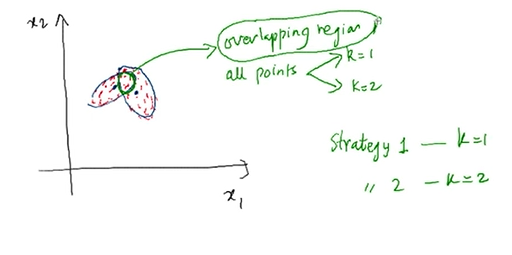

In [5]:
from IPython.display import Image
Image("D:/Capture.png")

here points in overlapping region they will be assigned to one of the two clusters if we use k means algo but the thing is it is better to have a probabilistic view for the points in overlapping region to understand better coz the CEO may want to employ different marketing strategy for the customers in the middle region....based on probabilities...in short it is better to have a probabilistic view sometimes

Now it's clear that if the model has some hidden, not observable parameters, then you should use GMM. This is because, this algorithm is assigning a probability to each point to belong to the certain cluster, instead of assigning a flag that the point belongs to the certain cluster as in the classical k-Means. Then, GMM is producing non-convex clusters, which can be controlled with the variance of the distribution. In fact, k-Means is a special case of GMM, such that the probability of one point to belong to a certain cluster is 1, and all other probabilities are 0, and the variance is 1, which a reason why k-Means produces only spherical clusters.

K means works on spherical shapes but GMM works on all kinds of shapes

Let's look at the advantages of using GMMs over K-Means.

- GMM is a lot more flexible in terms of cluster covariance:K-Means is actually a special case of GMM in which each cluster’s covariance along all dimensions approaches 0. This implies that a point will get assigned only to the cluster closest to it. With GMM, each cluster can have unconstrained covariance structure. Think of rotated and/or elongated distribution of points in a cluster, instead of spherical as in kmeans. As a result, cluster assignment is much more flexible in GMM than in k-means.
- GMM model accommodates mixed membership:Another implication of its covariance structure is that GMM allows for mixed membership of points to clusters. In kmeans, a point belongs to one and only one cluster, whereas in GMM a point belongs to each cluster to a different degree. The degree is based on the probability of the point being generated from each cluster’s (multivariate) normal distribution, with cluster center as the distribution’s mean and cluster covariance as its covariance. Depending on the task, mixed membership may be more appropriate (e.g. news articles can belong to multiple topic clusters) or not (e.g. organisms can belong to only one species).

### Limitations Fitting One Gaussian

In this session we will learn about the need of fitting 2 Gaussian instead of 1 Gaussian, please note that to better understand fitting 2 Gaussian, you need to have a clear idea of fitting 1 gaussian in the given data.

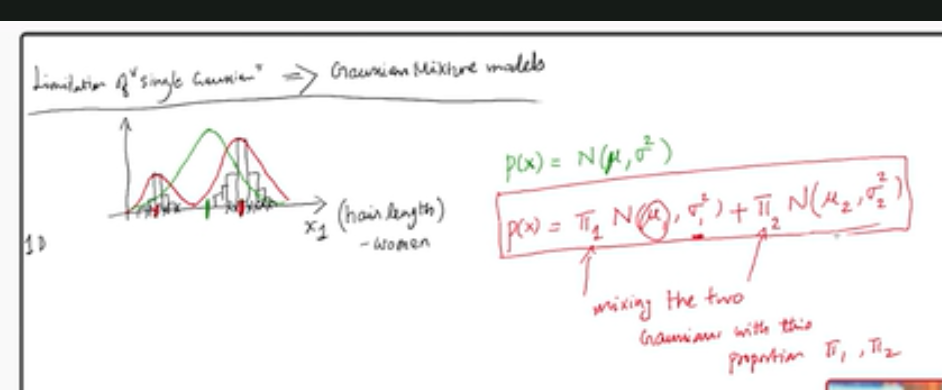

In [15]:
from IPython.display import Image
Image("D:/Capture.png")

So for fitting a 2 Gaussian for a given data, the modelling equation looks like,

 

P
(
X
)
=
π
1
N
(
μ
1
,
σ
2
1
)
+
π
2
N
(
μ
2
,
σ
2
2
)

 

Where 
π
1
 and 
π
2
 is the proportion in which the Gaussians are mixed in.

 

In the next lecture, we learn the about the need of 2 Gaussian using some examples.

"Speech Recognition" case involves 2D data, and we need to fit multiple Gaussians based on the application. We need to update our Gaussian parameters for a 2D Gaussian. In the next segment, we will learn about the parameters for 2D Gaussian.

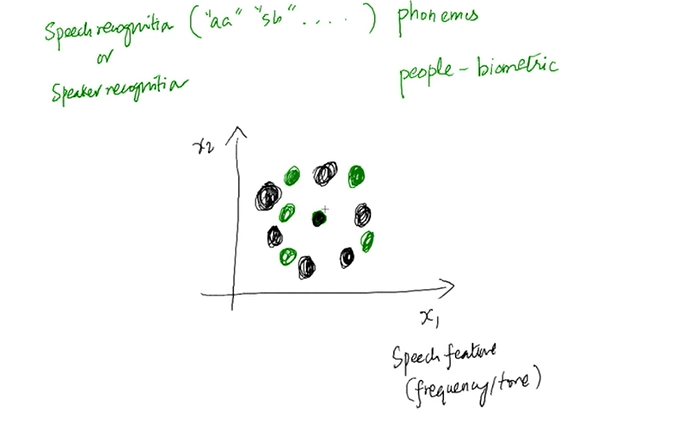

In [6]:
from IPython.display import Image
Image("D:/Capture.png")

"Speech Recognition" case involves 2D data, and we need to fit multiple Gaussians based on the application. We need to update our Gaussian parameters for a 2D Gaussian. In the next segment, we will learn about the parameters for 2D Gaussian.

Here having two guassians is preferred instead of one

 in the case of 2D, we will be getting introduced to the covariance matrix. The covariance matrix will allow us to capture different shapes in 2D, for example, a circle shape or an ellipse shape.

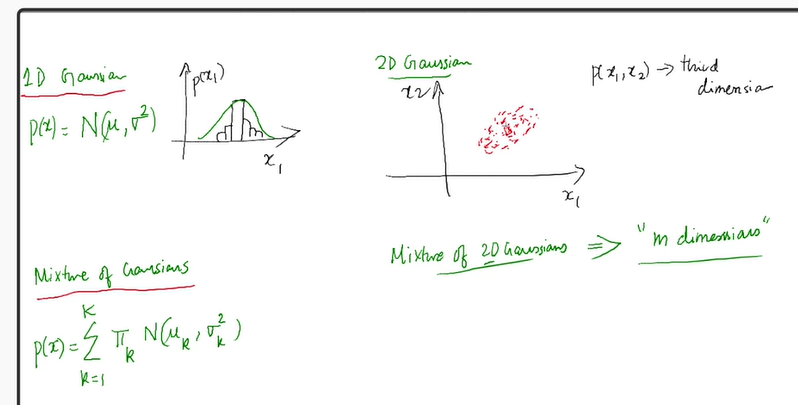

In [7]:
from IPython.display import Image
Image("D:/Capture.png")

To represent gaussian in 2D, we use iso-contour, and the alignment and the shape depend upon the covariance matrix.

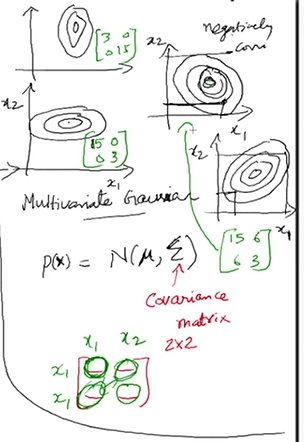

In [8]:
from IPython.display import Image
Image("D:/Capture.png")

To summarise we looked at,

- Limitations of K-Means(Overlapping data, Cluster shape).
- Need for multiple Gaussians in place of single Gaussian.
- The equation for multiple 1D Gaussians.
- Introduction to covariance matrix.
 

In the next segment, we will look how do we fit the data using a Gaussian mixture model.

### Gaussian Parameter Estimation

For a Gaussian Mixture Model, the equation is as follows,

 

P
(
X
)
=
π
1
N
(
μ
1
,
∑
1
)
+
π
2
N
(
μ
2
,
∑
2
)

 

To estimate a Gaussian Mixture Model we need to estimate parameters in the above equation, i.e. 
π
1
, 
π
2
, 
μ
1
, 
μ
2
, 
∑
1
 and 
∑
2

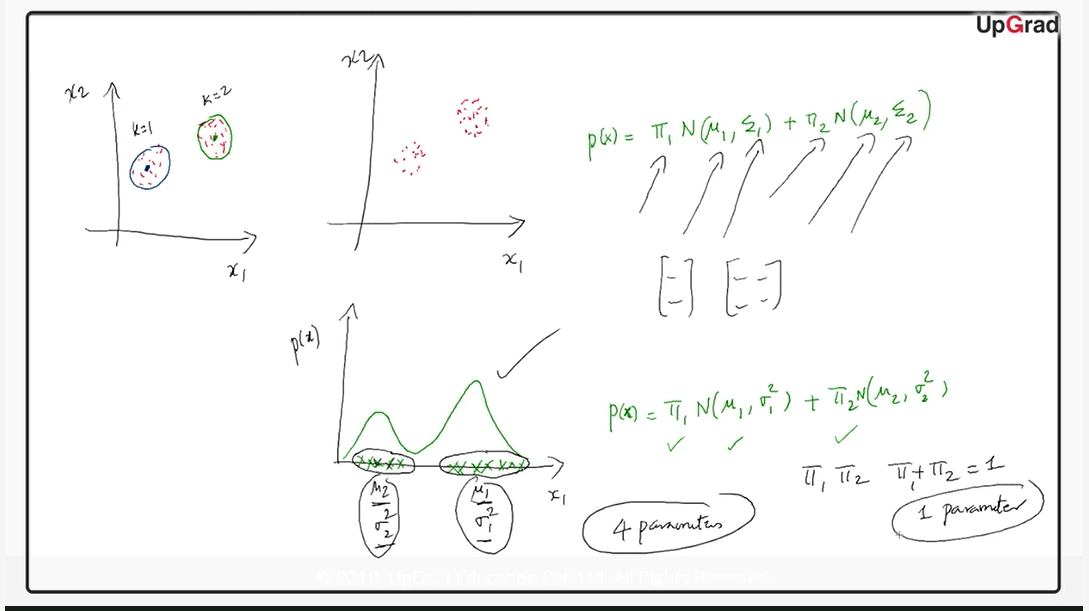

In [9]:
from IPython.display import Image
Image("D:/Capture.png")

Just like K-Means have two steps for making clusters, i.e. Assignment steps and optimisation step, for GMMs, we have the similar step called Expectation step and Maximisation step.

### Expectation Step

In this segment, we will focus on the Estimation steps for GMMs. To recall for K-Means, we follow the following steps,

Initialise the cluster centres.
Perform Assignment step.
Optimise the cluster centres.
Reiterate through step 2 and 3.
For GMMs, we have similar steps but have different computation. In the next lecture let's understand the Expectation step in detail by comparing the K-Means steps.

To initilise the GMMs algorithm we can use K-Means to compute 
μ
1
 and 
μ
2
. We can give equal weight to the Gaussians say 
π
1
=
0.5
 and 
π
2
=
0.5
, and then we can compute responsibilities that a cluster takes for each data points. Expectation steps assign each data point with a probability know as the soft assignment which is also known as the responsibility 
r
i
k
 that a cluster takes for each data point.

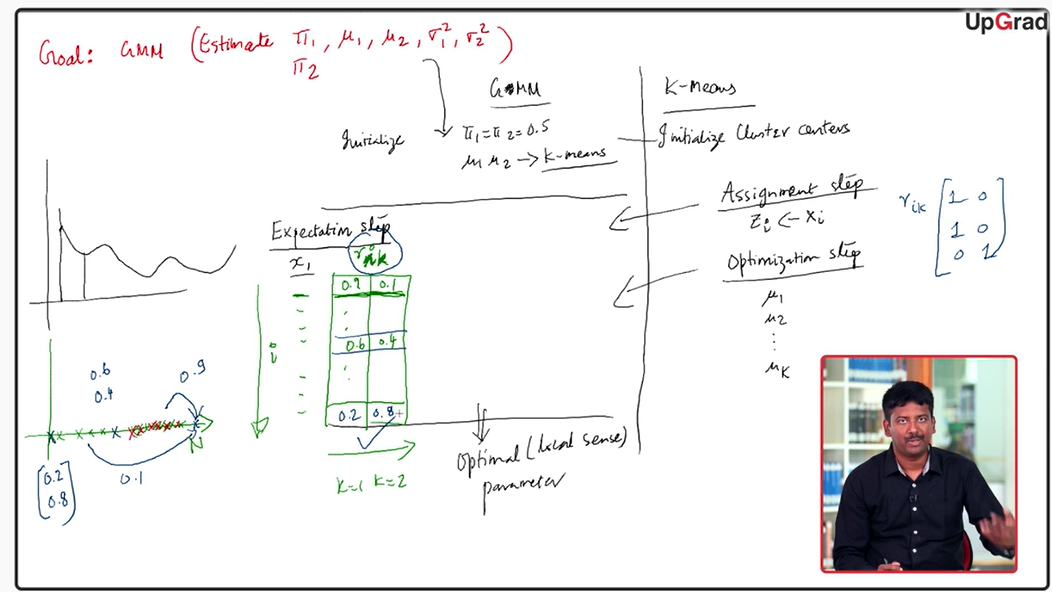

In [10]:
from IPython.display import Image
Image("D:/Capture.png")

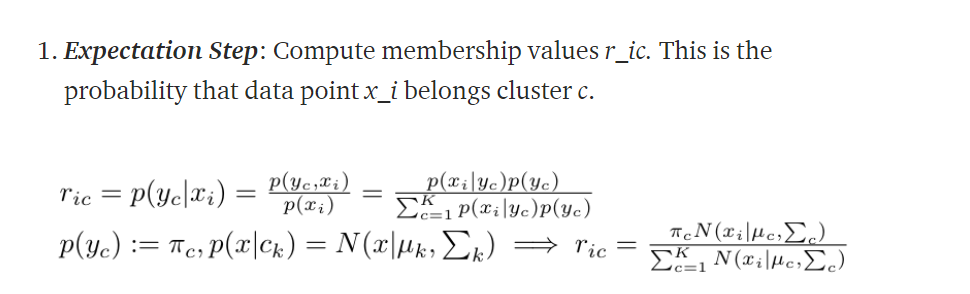

In [16]:
from IPython.display import Image
Image("D:/Capture.png")

### Maximisation Step

For K-Means, we recompute the cluster centres as the part of the optimisation step after we have assigned each data point to a cluster.

 

For GMMs we have a similar step in which we recompute the cluster centres 
μ
1
 and 
μ
2
 along with covariance matrix 
∑

 

Let's understand the Maximisation step for GMMs in the next lecture.

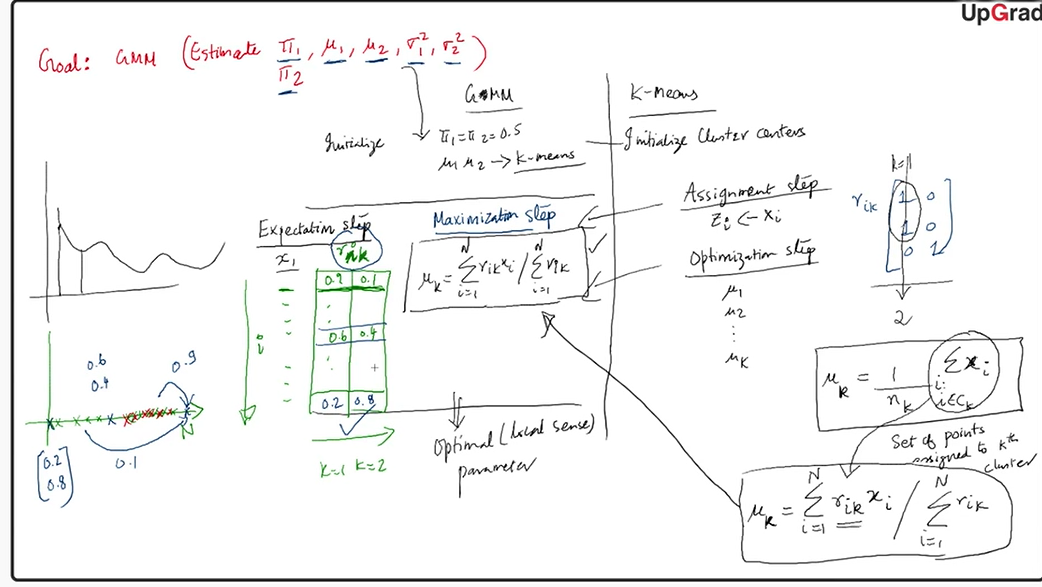

In [11]:
from IPython.display import Image
Image("D:/Capture.png")

You may refer to this document to learn about the exact equation that GMM follows.: https://brilliant.org/wiki/gaussian-mixture-model/

### Working Example with E-M for GMMs

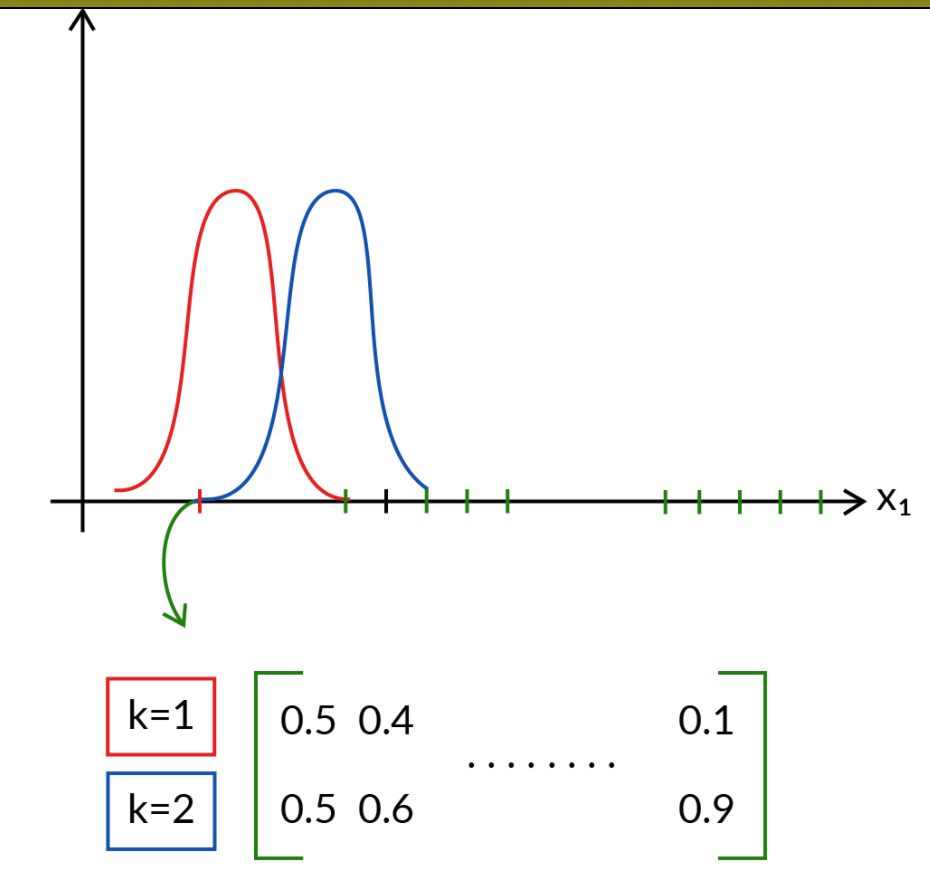

In [12]:
from IPython.display import Image
Image("D:/Capture.png")

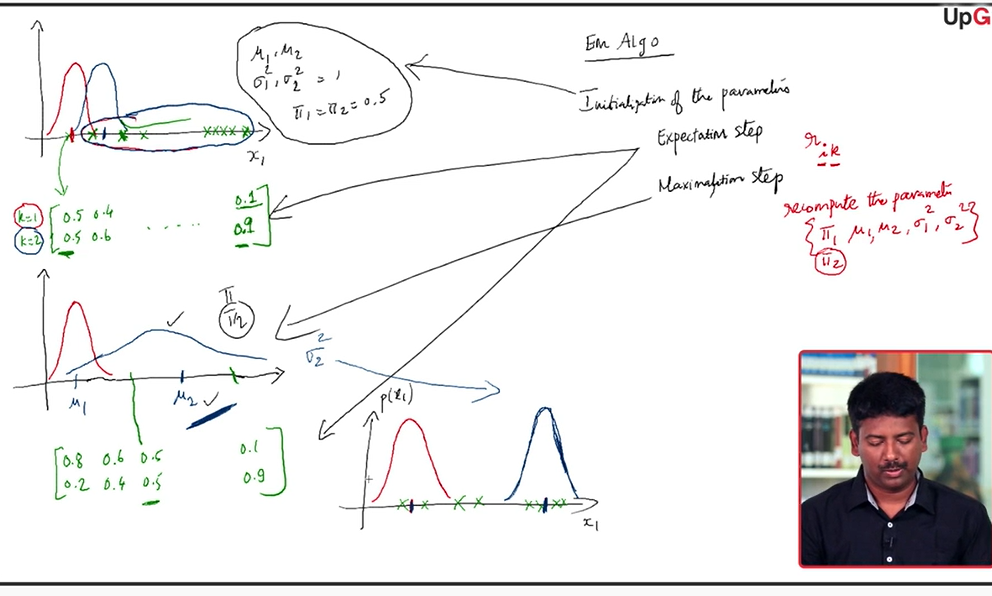

In [13]:
from IPython.display import Image
Image("D:/Capture.png")

For Maximisation steps, we saw that the 
μ
1
 and 
μ
2
 got recomputed together with the variance which is more for blue Gaussian than green Gaussian. 

 

We can recompute the responsibilities based on the recomputed 
μ
 and 
σ
 and iterate through this step until the solution converges